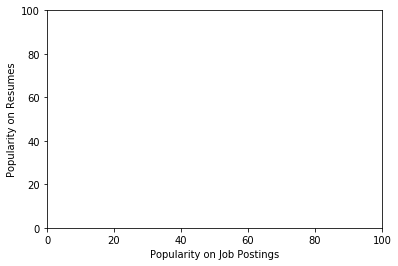

In [19]:
'''
自然語言處理 (Natural Language Processing, NLP)
'''
import math, random, re
from collections import defaultdict, Counter
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import requests

def plot_resumes(plt):
    data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]
    
    def text_size(total):
        '''
        如果 total 是 0 就送出 8，如果 total 是 200 就送出 28
        '''
        return 8 + total / 200 * 20
    
    for word, job_popularity, resume_popularity in data:
        plt.text(job_popularity, resume_popularity, word,
                ha='center', va='center',
                size=text_size(job_popularity + resume_popularity))
        
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
# plt.xticks([])
# plt.yticks([])
plt.show()

In [21]:
'''
n-gram 模型
'''
# 消除文字中的撇號
def fix_unicode(text):
    return text.replace(u"\u2019", "'")

# 把文字拆成一系列的單詞和句號
from bs4 import BeautifulSoup
import requests

def get_document():
    url = "http://radar.oreilly.com/2010/06/what-is-data-science.html"
    html = requests.get(url).text
    soup = BeautifulSoup(html, 'html5lib')

    content = soup.find("div", "article-body")     # 在 div 的內容中尋找
    regex = r"[\w']+|[\.]"                          # 單詞或句號

    document = []

    for paragraph in content("p"):
        words = re.fillall(regex, fix_unicode(paragraph.text))
        document.extend(words)
        
    return document

In [32]:
# 使用 zip 壓合和連接兩個單詞
# 2-gram model

bigrams = zip(document, document[1:])
transitions = defaultdict(list)
for prev, current in bigrams:
    transition[prev].append(current)
    
def generate_using_bigrams(transitions):
    current = "."   # 這表示下一個單詞將是某個句子的起始單詞
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # 隨機挑選其中一個
        result.append(current)                         # 添加到結果後面
        if current == ".": return " ".join(result)     # 如果遇到 "." 就完成了

In [36]:
# 3-gram model

trigrams = zip(document, document[1:], document[2:])
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next in trigrams:
    if prev == ".":                 # 如果前一個單詞是句號
        starts.append(current)      # 目前這個就是起始單詞
        
    trigram_transitions[(prev, current)].append(next)

    
def generate_using_trigrams(starts, trigram_transitions):
    current = random.choice(starts)   # 隨機選擇一個初始單辭
    prev = "."                        # 前面是一個句號
    result = [current]
    while True:
        next_word_candidates = trigram_transitions[(prev, current)]
        next = random.choice(next_word_candidates)

        prev, current = current, next
        result.append(current)

        if current == ".":
            return " ".join(result)

In [41]:
'''
文法 (grammar)
'''
grammar = {
        "_S"  : ["_NP _VP"],
        "_NP" : ["_N",
                 "_A _NP _P _A _N"],
        "_VP" : ["_V",
                 "_V _NP"],
        "_N"  : ["data science", "Python", "regression"],
        "_A"  : ["big", "linear", "logistic"],
        "_P"  : ["about", "near"],
        "_V"  : ["learns", "trains", "tests", "is"]
    }

# 把 token 列表轉換成一個句子
def is_terminal(token):
    return tocken[0] != "_"

# 以空白隔開的非終端文字來拆散
def expand(grammar, tokens):
    for i, token in enumerate(tokens):
        # 跳過終端文字
        if is_terminal(token): continue
        
        # 如果遇上一個非終端文字
        # 必須隨機選一個來取代
        replacement = random.choice(grammar[token])
        
        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
        
        # 現在再針對新的 token 列表，遞迴呼叫 expand 函式
        return expand(grammar, tokens)
    
    # 全部都是終端文字時，就完成
    return tokens

# 製造句子
def generate_sentence(grammar):
    return expand(grammar, ["_S"])

In [47]:
'''
Gibbs 取樣
'''
import random

random.random()
# inverse_normal_cdf(random.random())

# 範例: 擲骰子
def roll_a_die():
    return random.choice([1,2,3,4,5,6])

def direct_sample():
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

# 在已知 x的條件下，y 的分布
def random_y_given_x(x):
    '''
    只可能等於 x + 1, x + 2, ... , x + 6 
    '''
    return x + roll_a_die()

# 在已知 y的條件下，x 的分布
def random_x_given_y(y):
    if y <= 7:
        # 如果總點數小於等於 7，第一個骰子的點數就有可能是
        # 1, 2, ..., (總點數 - 1)
        return random.randrange(1, y)
    else:
        # 如果總點數大於 7，第一個骰子就有可能是
        # (總點數 - 6), (總點數 - 5), ..., 6
        return random.randrange(y - 6, 7)

In [49]:
# 經過重複多次迭代
# 無條件聯合分布的一個樣本值
def gibbs_sample(num_iters=100):
    x, y = 1, 2          # 只要合理，選甚麼值都沒關係
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

def compare_distributions(num_samples=1000):
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [53]:
'''
主題模型話 (topic model)
'''
def sample_from(weights):
    '''
    根據 (權重值 / 權重總和) 的機率，進行隨機取樣，然後送出權重索引值 i
    '''
    total = sum(weights)
    rnd = total * random.random()       # 0 到 total 之間，每個值出現的機率皆相同
    for i, w in enumerate(weights):
        rnd -= w                        # 送回滿足以下條件的最小 i 值
        if rnd <= 0: return i           # sum(weights[:(i+1)]) >= rnd
        
        
documents = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

K = 4

# 計數結果列表，每個文件都對應一組主題計數結果
document_topic_counts = [Counter()
                         for _ in documents]

# 計數結果列表，每個主題對應一組單詞計數結果
topic_word_counts = [Counter() for _ in range(K)]

# 數字列表，每個主題對應一個數字
topic_counts = [0 for _ in range(K)]

# 數字列表，每個文件對應一個數字
document_lengths = [len(d) for d in documents]

# 不重複的單詞數量 (W)
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

# 文件的數量 (D)
D = len(documents)

# document[3]中被歸類為主題 1 的單詞數量
print("document_topic_counts[3][1] :", document_topic_counts[3][1])
# 主題 2中 nlp 這個單詞出現的次數
print("document_topic_counts[2]['nlp'] :", document_topic_counts[2]['nlp'])

document_topic_counts[3][1] : 0
document_topic_counts[2]['nlp'] : 0


In [55]:
# 定義條件機率函數
def p_topic_given_document(topic, d, alpha=0.1):
    '''
    在文件 d 中，被指定為某主題的單詞所佔比例
    也就是某主題出現在文件 d 中的機率 (已導入平滑項)
    '''
    return ((document_topic_counts[d][topic] + alpha) / 
            (document_lengths[d] + K * alpha))
            
def p_word_given_topic(word, topic, beta=0.1):
    '''
    被指定為某主題的某單詞，在該主題中所佔比例
    也就是某單詞在該主題中出現的機率　(已導入平滑項)
    '''
    return ((topic_word_counts[topic][word] + beta) / 
           (topic_counts[topic] + W * beta))

# 建立新函數來計算新的權重值
def topic_weight(d, word, k):
    '''
    給定一個文件，以及文件中的一個單詞，
    就可以送回第 k 個主題的權重值
    '''
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d, word):
    return sample_from([topic_weight(d, word, k)
                       for k in range(K)])

In [61]:
# 為每個單詞指定某個隨機的主題
# 逐一計算出前面所提的相應計數值
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                  for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1
        
# 以 Gibbs取樣的形式來做
for iter in range(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                             document_topics[d])):
            # 從計數值中移除這個單詞 / 主題
            # 就不會影響到權重值
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1
            
            # 根據新權重值設定一個新的主題
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic
            
            # 然後再把它加回到計數值之中
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

In [80]:
# 找出權重最高的五個單詞
print("topic \t", "word \t\t", "count")

for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0: print(k, "\t", word, "\t", count)

topic 	 word 		 count
0 	 scikit-learn 	 12
0 	 pandas 	 12
0 	 Big Data 	 10
0 	 HBase 	 6
0 	 R 	 6
0 	 Java 	 6
0 	 C++ 	 6
0 	 Haskell 	 6
0 	 artificial intelligence 	 6
0 	 statsmodels 	 6
0 	 statistics 	 5
0 	 scipy 	 5
0 	 numpy 	 5
0 	 mathematics 	 5
0 	 deep learning 	 5
0 	 regression 	 1
0 	 Hadoop 	 1
0 	 libsvm 	 1
1 	 neural networks 	 12
1 	 MongoDB 	 11
1 	 deep learning 	 7
1 	 HBase 	 6
1 	 decision trees 	 6
1 	 theory 	 6
1 	 Mahout 	 6
1 	 databases 	 6
1 	 Postgres 	 6
1 	 MySQL 	 6
1 	 Cassandra 	 1
1 	 Python 	 1
1 	 numpy 	 1
1 	 Big Data 	 1
1 	 statistics 	 1
2 	 Python 	 17
2 	 regression 	 17
2 	 R 	 17
2 	 Java 	 12
2 	 Cassandra 	 11
2 	 probability 	 11
2 	 machine learning 	 11
2 	 statistics 	 11
2 	 Postgres 	 6
2 	 statsmodels 	 6
2 	 C++ 	 6
2 	 artificial intelligence 	 6
2 	 HBase 	 6
2 	 Storm 	 5
2 	 programming languages 	 5
2 	 MongoDB 	 1
2 	 scipy 	 1
2 	 mathematics 	 1
3 	 Hadoop 	 11
3 	 libsvm 	 11
3 	 Big Data 	 7
3 	 probability 	 7

In [84]:
# 替主題指定下列名稱
topic_names = ["Big Data and programming languages",
               "databases",
               "machine learning",
               "statistics"]

for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count,
                 print())

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']

statistics 19 None

machine learning 17 None

Big Data and programming languages 6 None
['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']

machine learning 17 None

databases 7 None

statistics 6 None
['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']

Big Data and programming languages 22 None

machine learning 12 None

databases 2 None
['R', 'Python', 'statistics', 'regression', 'probability']

machine learning 22 None

Big Data and programming languages 7 None

statistics 1 None
['machine learning', 'regression', 'decision trees', 'libsvm']

machine learning 11 None

statistics 7 None

databases 6 None
['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']

machine learning 16 None

Big Data and programming languages 13 None

statistics 7 None
['statistics', 'probability', 'mathematics', 'theory']

Big Data and programming languages 10 None

databases 7 None

statistics 6 None